In [15]:
import matplotlib.pyplot as plt  
import numpy as np 
from keras import datasets
from sklearn.decomposition import PCA 
from matplotlib import cm
import matplotlib.pyplot as plt

In [16]:
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter
    
if is_notebook():
    from tqdm import notebook as tqdm
else:
    from tqdm import tqdm


#### **Load FashionMNIST dataset** 

In [17]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

print(f'Number of training examples: {x_train.shape[0]}')
print(f'Number of testing examples: {x_test.shape[0]}')
print(f'Shape of the images: {x_train.shape[1:]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training examples: 60000
Number of testing examples: 10000
Shape of the images: (28, 28)
Number of classes: 10


#### **Visualize Sample**

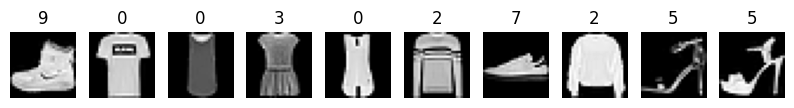

In [18]:
pltsize= 1 
plt.figure(figsize=(10*pltsize, pltsize*1.1))

for i in range(10): 
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'{y_train[i]}')

In [19]:
%%time 
c = np.nan_to_num(np.corrcoef(x_train.reshape(x_train.shape[0], -1).T))
c.shape, c.min(), c.max()

CPU times: total: 1.52 s
Wall time: 315 ms


((784, 784), -0.6577623419657886, 1.0)

Text(0.5, 1.0, 'Sum of cross-correlation matrix')

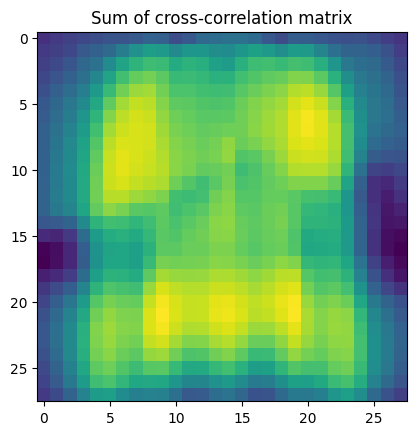

In [20]:
fig = plt.figure()
plt.imshow(c.sum(axis=0).reshape(28,28), interpolation='nearest')
plt.title('Sum of cross-correlation matrix')

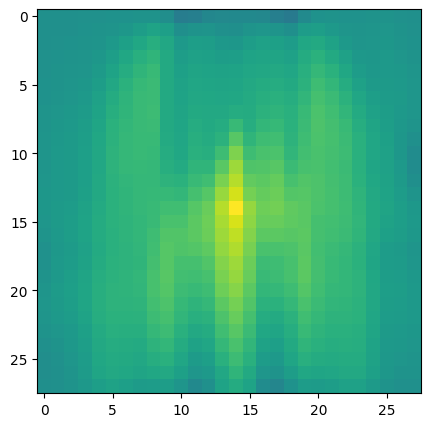

In [21]:
# show 2D histogram of the correlation matrix
size_dim = 28 
data = c.reshape(size_dim, size_dim, size_dim, size_dim)
fig = plt.figure() 
ax = fig.add_axes([.1, .1, .8, .8])
implot = ax.imshow(data[size_dim>>1, size_dim>>1].reshape(size_dim, size_dim),
                   interpolation='nearest', clim=(-1,1))
text=ax.text(-.5,-1, "", va="bottom", ha="left")
last_x, last_y = -1, -1
def onmotion(event):
    global last_x
    global last_y
    global data
    global side_dim
    global text
    global implot
    x = int(np.rint(event.xdata))
    y = int(np.rint(event.ydata))
    if last_x != x or last_y != y and x >=0 and y >= 0:
        implot.set_array(data[y, x].reshape(side_dim, side_dim))
        last_x = x
        last_y = y

cid = implot.figure.canvas.mpl_connect('motion_notify_event', onmotion)

#### **First PCs for FashionMNIST** 

CPU times: total: 8.17 s
Wall time: 1.42 s


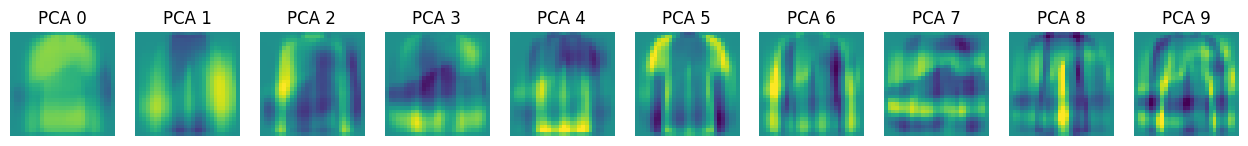

In [22]:
%%time 
n_components = 10 
pca = PCA(n_components=n_components) 
pca.fit(x_train.reshape(x_train.shape[0], -1))

fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3)) 
axes = list()
for i in range(n_components): 
    axes.append(fig.add_subplot(1, n_components, i+1))
    axes[i].imshow(pca.components_[i].reshape(28,28), interpolation='nearest', clim=(-.10,.10))
    axes[i].set_title(f'PCA {i}')
    axes[i].axis('off') 

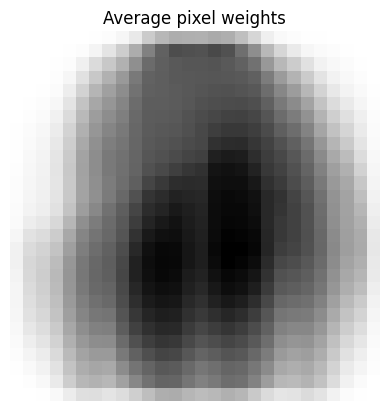

Max of mean: 161.87638333333334


In [23]:
# show average pixel weights
fig = plt.figure() 
plt.imshow(x_train.mean(axis=0).reshape(28,28), cmap = cm.binary)
plt.title('Average pixel weights')
plt.axis('off')
plt.show()
print(f'Max of mean: {x_train.mean(axis=0).max()}')

#### **Effect of Iterative PCs**

In [24]:
def fib(n):
    a, b = 1, 2  # Normally we'd start at 0, 1, but we don't want that...
    for _ in range(n):
        yield a
        a, b = b, a + b

<class 'numpy.ndarray'> (10, 784)


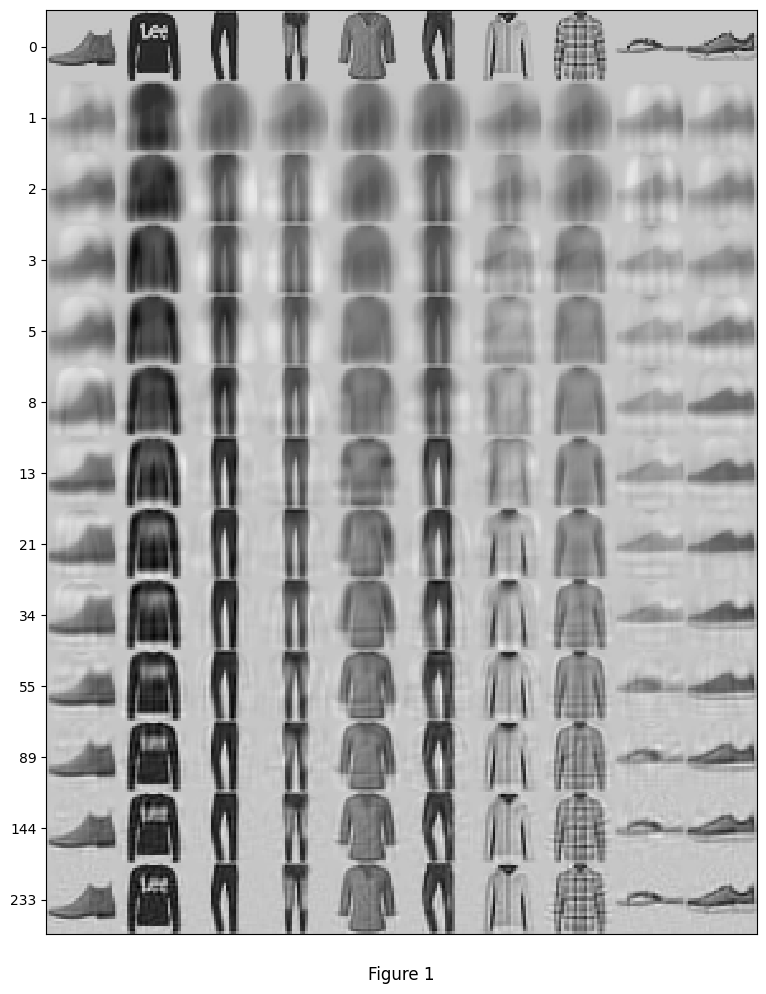

In [25]:
# Try PCA on the first 10 Fibonacci numbers
n_images = 10
n_components = 12
test_images = np.array((x_test[:n_images]).reshape(n_images, 784))
print(type(test_images), test_images.shape)

# Plot the test images and the corresponding outputs 
fig = plt.figure(figsize= (10, n_components))
ax = fig.add_subplot(1, 1, 1) 
images_in = [test_images[i].reshape(28,28) for i in range(n_images)]
image = np.concatenate(images_in, axis=1)

for i in fib(n_components):
    pca = PCA(n_components=i)
    pca.fit(x_train.reshape(x_train.shape[0], -1))
    test_outputs = pca.inverse_transform(pca.transform(test_images))
    images_out = [test_outputs[j].reshape(28,28) for j in range(n_images)]
    image_out = np.concatenate(images_out, axis=1)
    image = np.concatenate([image, image_out], axis=0)

ax.matshow(image, cmap= cm.binary)
ax.set_xticks(np.array([]))
y_lim = ax.get_ylim()
y_scale = (y_lim[0] - y_lim[1]) / (n_components + 1) 
ax.set_yticks(np.linspace(.5, n_components + .5, n_components+ 1) * y_scale)
a = [0]
a.extend(list(fib(n_components)))
ax.set_yticklabels(a)
ax.text(0.5, -0.05, "Figure 1", transform=ax.transAxes, ha='center', fontsize=12)

plt.show()

In [26]:
test_images = np.array((x_test[:10000]).reshape(10000, 784))

In [27]:
def draw_apply_PC0(idx):
    fig = plt.figure(figsize=(5,3))
    pca0_applied = pca.components_[0].reshape(28, 28) * pca.transform(test_images)[idx][0]
    image = pca.mean_.reshape(28, 28) + pca0_applied

    absmin = np.min([test_images[idx].min(), pca.mean_.min(), pca0_applied.min(), image.min()])
    absmax = np.max([test_images[idx].max(), pca.mean_.max(), pca0_applied.max(), image.max()])

    ax_ = fig.add_subplot(1, 4, 1)
    ax_.imshow(test_images[idx].reshape(28,28), interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'original')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 2)
    ax_.imshow(pca.mean_.reshape(28,28), interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'mean')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 3)
    ax_.imshow(pca0_applied, interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'PC 1')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 4)
    ax_.imshow(image, interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'Applied')
    ax_.axis('off')

    print(f'PC_0 min: {pca.components_[0].min():.4f},\tPC_0 max: {pca.components_[0].max():.4f}')
    print(f'mean_img min: {pca.mean_.min():.4f},\tmean_img max: {pca.mean_.max():.4f}')
    print(f'Ammount to apply_{idx}: {pca.transform(test_images)[idx][0]:.4f}')

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(pca.transform(test_images[idx].reshape(1, -1)).flatten())
    ax.axhline(0, lw=.5, color='k') # horizontal lines

    ax.set_title('Amount of each PC applied.')

PC_0 min: -0.0364,	PC_0 max: 0.0653
mean_img min: 0.0008,	mean_img max: 161.8764
Ammount to apply_127: 1244.5472
PC_0 min: -0.0364,	PC_0 max: 0.0653
mean_img min: 0.0008,	mean_img max: 161.8764
Ammount to apply_242: 353.1437
PC_0 min: -0.0364,	PC_0 max: 0.0653
mean_img min: 0.0008,	mean_img max: 161.8764
Ammount to apply_1886: 1315.3428
PC_0 min: -0.0364,	PC_0 max: 0.0653
mean_img min: 0.0008,	mean_img max: 161.8764
Ammount to apply_1207: -619.6320
PC_0 min: -0.0364,	PC_0 max: 0.0653
mean_img min: 0.0008,	mean_img max: 161.8764
Ammount to apply_2402: 325.7413


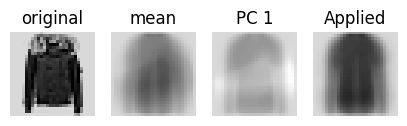

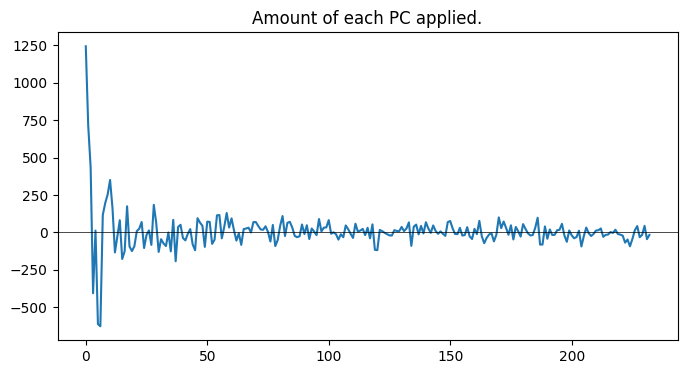

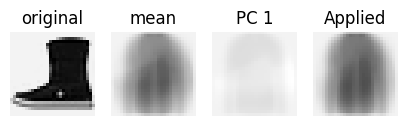

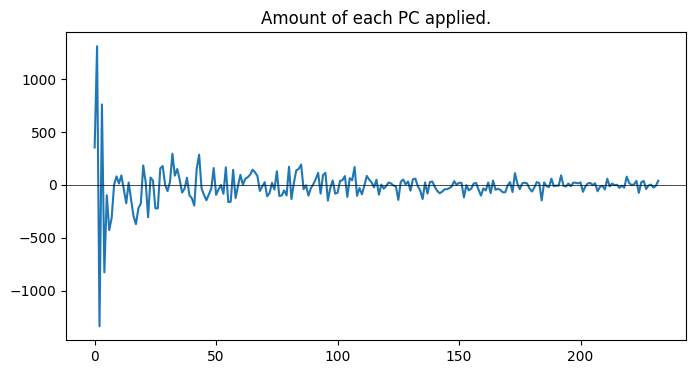

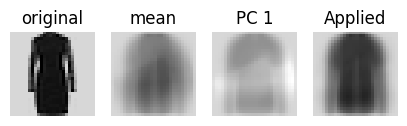

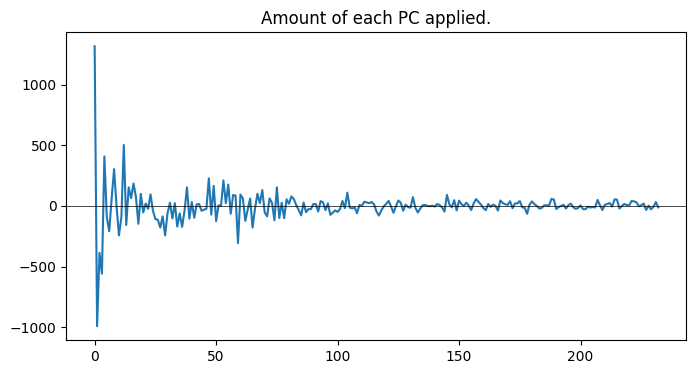

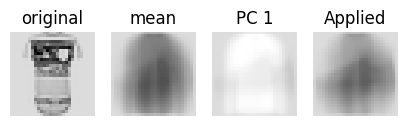

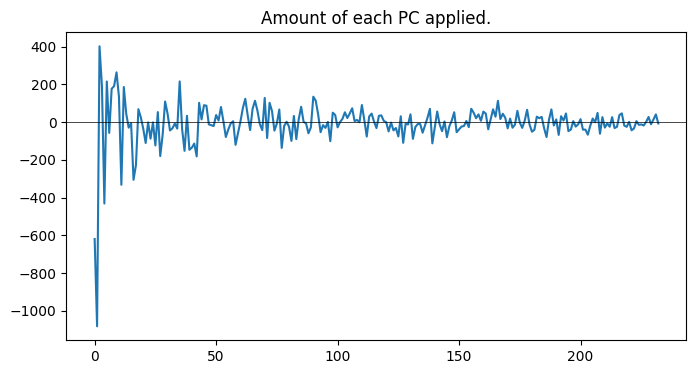

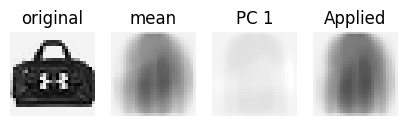

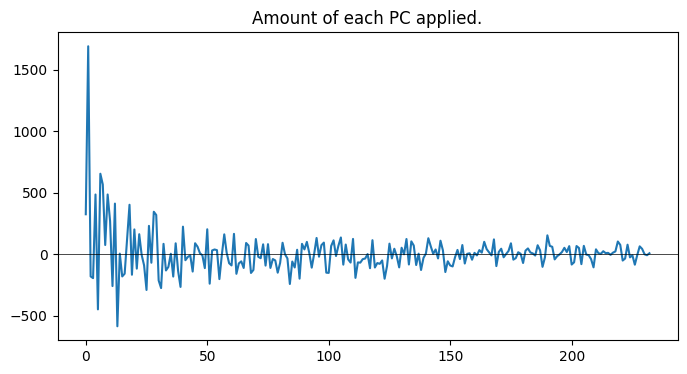

In [28]:
list_idx = [127, 242, 1886, 1207, 2402]
for idx in list_idx:
    draw_apply_PC0(idx)

## **Nhận xét**

Dựa vào kết quả của quá trình thực nghiệm, chúng tôi rút ra một số nhận xét như sau: 
1. Về kết quả ở ```Figure 1``` có thể thấy khi thành phần (n_componets) càng lớn, tức là số chiều dữ liệu mới càng lớn thì ảnh càng rõ nét, và càng giống với ảnh gốc hơn. Bên cạnh đó, với n_components= 0 thì sẽ giữ nguyên ảnh gốc ban đầu. 

2. Đối với kết quả khi thực hiện áp dụng thành phần PCA đầu tiên lên một số ảnh trong tập test, thì với chỉ số ```Amount to apply``` (đại diện cho phép chiếu của một test lên first principal component) càng cao thì ảnh kết quả khi được áp dụng PCA sẽ càng giống với ảnh gốc hơn. 

3. Tuy nhiên, cũng có trường hợp chỉ số ```Amount to apply``` ra kết quả ấm (như ảnh test thứ 127)
và chúng ta không còn nhận dạng được hình ảnh của vật thể trong kết quả được áp dụng bởi PCA. Bên cạnh đó, thì đối với các giá trị thấp (như ảnh test thứ 242 hay 2402) thì khi áp dụng PCA lên thì có thể thấy ảnh kết quả ra một vật thể khác không giống so với ảnh gốc. 

4. Dựa trên các giá trị **PC0_min** và **PC0_max** có thể thấy biên độ tương đối nhỏ (-0.0364 đến 0.0653). Điều này thể hiện mức độ biến động dữ liệu tương đối nhỏ

5. Bên cạnh đó, các giá trị **mean_img min**  và **mean_img max** (lần lượt các giá trị pixel nhỏ và lớn nhất trong hình ảnh trung bình khi áp dụng PCA) nằm trong khoảng (0.008 , 161.8764) là các giá trị pixel nằm trong khoảng hợp lý so với hình ảnh gốc. Điều này thể hiện PCA có thể bảo tồn được một phần thông tin quan trọng của hình ảnh gốc 